In [1]:
import numpy as np
#import tensorflow as tf
#from tensorflow.python.client import device_lib
import pandas as pd
from zipfile import ZipFile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from skimage import exposure
#from skimage.color import rgb2gray
import platform
import sys
from datetime import datetime
%matplotlib inline

In [25]:
driving = "driving_01"

input_files = []

# read CSV file with steering angle
csvdata = pd.read_csv("./data/" + driving + ".csv", header=None)
#samples = [csvdata.iloc[:, 0].values, csvdata.iloc[:, 3].values]
samples = csvdata.iloc[:, [1, 3]].values
nlabels = csvdata.shape[0]

# original shape
owidth = 320
oheight = 160

# crop
stripetop = 60
stripebot = 20

def generator(samples, batch_size=32):
    num_samples = len(samples)
    # 
    # Loop forever so the generator never terminates
    #  but it only executes when code calls "next()"
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data/'+ driving + '/'+batch_sample[0].split('/')[-1]
                #center_image = cv2.imread(name)
                center_image = mpimg.imread(name, format='jpeg')
                center_angle = float(batch_sample[1])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# 
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#print(train_samples)

# Python automatically interprets the function as generator, and WON'T execute it right away
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
# 
print(train_generator)

<generator object generator at 0x7f6cb960ce60>


In [23]:
print(len(train_samples))
print(samples[0])
print(type(samples))

56
[ '/Users/bgcarvalho/Documents/Personal/pos_nanodegree_SDC/CarND-Term1-P3/data/IMG/left_2017_10_25_18_12_51_924.jpg'
 0.0]
<class 'numpy.ndarray'>


continue

Could use sample data (provided) as test:

In [4]:
#testdata = pd.read_csv("./sample-data/driving.csv", header=None)
#y_test = y_test + testdata.iloc[:, 3]


# Model Architecture

The proposed model has 5 convolutional layers and 4 fully connected.

In [5]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Lambda, MaxPooling2D
from keras.layers import Cropping2D
from keras.callbacks import EarlyStopping
from keras import __version__ as keras_version
import h5py

Using TensorFlow backend.


In [6]:
model = Sequential()

# CROP images
model.add(Cropping2D(cropping=((stripetop, stripebot), (0,0)), input_shape=(oheight, owidth, 3)))

# normalization and mean centering
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

# layer 1 - convolutional
#model.add(Conv2D(512, (3, 3), activation='relu', input_shape=(X_data.shape[1], X_data.shape[2], X_data.shape[3])))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 2
#model.add(Conv2D(256, (3, 3), activation='relu'))

# layer 3
#model.add(Conv2D(128, (3, 3), activation='relu'))

# layer 4
#model.add(Conv2D(64, (3, 3), activation='relu'))

# layer 5
#model.add(Conv2D(32, (3, 3), activation='relu'))

#model.add(Dropout(0.5))
model.add(Flatten())

# layer 6
#model.add(Dense(1))
#model.add(Dropout(0.5))

# layer 7
#model.add(Dense(1000, activation='relu'))

# layer 8
#model.add(Dense(100, activation='relu'))
#model.add(Dense(10, activation='relu'))

# layer 9
model.add(Dense(1))

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 318, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 159, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 99216)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 99217     
Total params: 99,665
Trainable params: 99,665
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
ee = 1e-6
cb_earlystop = EarlyStopping(min_delta=ee, patience=3, verbose=1)

# compile model
model.compile(loss='mse', optimizer='adam')

# train
history = model.fit_generator(train_generator, 
                              samples_per_epoch=len(train_samples),
                              validation_data=validation_generator,
                              nb_val_samples=len(validation_samples), 
                              nb_epoch=3,
                              verbose=1)
# save to disk
model.save('model.h5')


/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=3, validation_data=<generator..., verbose=1, steps_per_epoch=56, validation_steps=14)`


Epoch 1/3
56/56 [==============================] - 6s - loss: 0.5990 - val_loss: 0.0265
Epoch 2/3
56/56 [==============================] - 2s - loss: 0.0015 - val_loss: 0.0104
Epoch 3/3
56/56 [==============================] - 2s - loss: 5.7952e-06 - val_loss: 0.0102


{'loss': [0.57677144636649502, 0.0014631472959498919, 5.866923598478372e-06], 'val_loss': [0.026542633505804197, 0.010443174945456641, 0.010197218707097428]}


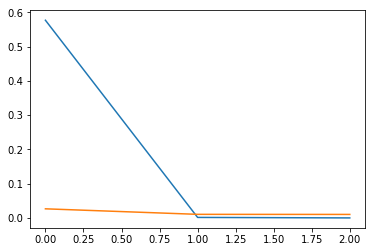

In [31]:
print(history.history)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Evaluate

In [ ]:
from keras.models import load_model

In [ ]:
test_generator = generator(test_samples, batch_size=32)

model.load_model('model.h5')
score = model.evaluate_generator(test_generator, batch_size=32)
print(score)